[Table of contents](../toc.ipynb)

# Calibration of a vehicle single track model

This notebook presents parameter estimation of a vehicle single track model given reference data from a double lane model of Simulink vehicle dynamics library.

The steps herein are similar to a recent paper of mine [[Rhode2019]](../references.bib), and you can find the according code to this paper on boschresearch at github: [https://github.com/boschresearch/iccve2019_valmon](https://github.com/boschresearch/iccve2019_valmon) if you are interested.

## Single track model

<img src="single-track-model.png" alt="single-track-model" width="400" align="right">

The vehicle single track model describes lateral vehicle dynamics accurately upon roughly 4 meters per square second lateral acceleration. The tires are merged into a single tire per axle, and the center of gravity is on same height as the track. Hence, just yaw is considered, no pitch or roll dynamics.

The state space form of the single track model is

\begin{equation*} \begin{bmatrix} \ddot{\psi}\\ \dot{\beta} \end{bmatrix}= \begin{bmatrix} -\frac{1}{v} \frac{c_{f} l_{v}^{2}+c_{r} l_{r}^{2}}{\Theta} & -\frac{c_{f} l_{f}-c_{r} l_{r}}{\Theta}\\ -1-\frac{1}{v^{2}} \frac{c_{f} l_{f}-c_{r} l_{r}}{m} & -\frac{1}{v} \frac{c_{f}+c_{r}}{m} \end{bmatrix} \begin{bmatrix} \dot{\psi}\\ \beta \end{bmatrix} + \begin{bmatrix} \frac{c_{f} l_{f}}{\Theta}\\ \frac{1}{v} \frac{c_{f}}{m} \end{bmatrix} \delta \end{equation*}

and you can find its derivation and more description in page 230 of [[Schramm2018]](../references.bib).

$\dot{\psi}$ denotes the yaw rate, $\beta$ the side slip angle, $c_{f,r}$ are the front and rear conering stiffness, $l_{f, r}$ front and rear distance from axle to center of gravity, $\Theta$ denotes the yaw inertia, $m$ the vehicle mass, $v$ the velocity, and $\delta$ denotes the wheel angle, which acts as model input.

## Double lane model

The reference data was generated with a standard double lane model in Simulink, which is presented in next figure.

<img src="double-lane-model.png" alt="double-lane-model" width="800">

* All parameters were kept at default values.
* A sine wave was used to stimulate the model input for $0<t<30$ seconds.

This Simulink model is attached to this repository here [dual_track_model.slx](dual_track_model.slx) and you can use the file [to_csv.m](to_csv.m) to save its result as csv files.

## Some preparation

First, let us import some Python packages.

In [25]:
from scipy.optimize import minimize
import control
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

The next code block is a helper function to make the csv files available for the Jupyter notebook and Pytest.

In [26]:
# This if else is a fix to make the file available for Jupyter and Travis CI
import os


def find_csv(filename):
    if os.path.isfile(filename):
        file = filename
    else:
        file = '04_mini-projects/' + filename
    return file

Now, we import the data from the double lane model's csv files with `np.genfromtxt`. The first row is time, the second row is the signal value.

In [27]:
wheel_ang = np.genfromtxt(find_csv('wheel_angle.csv'), delimiter=",")
beta = np.genfromtxt(find_csv('beta.csv'), delimiter=",")
psi = np.genfromtxt(find_csv('psi.csv'), delimiter=",")

It will be convenient to have some common plot function in the latter. So, let us define one.

In [28]:
def plot_input_and_states(psi, beta, title):
    plt.figure()
    plt.plot(wheel_ang[1])
    plt.plot(psi)
    plt.plot(beta)
    plt.legend(
        ["Wheel angle in rad", r"$\dot{\psi}$ in rad per second", r"$\beta$ in rad", ])
    plt.xlabel("time in 1/100 seconds")
    plt.title(title)
    plt.show()

And here is the figure for the double lane model. You can see that the wheel angle is a sine wave which stops from $t>30$ seconds.

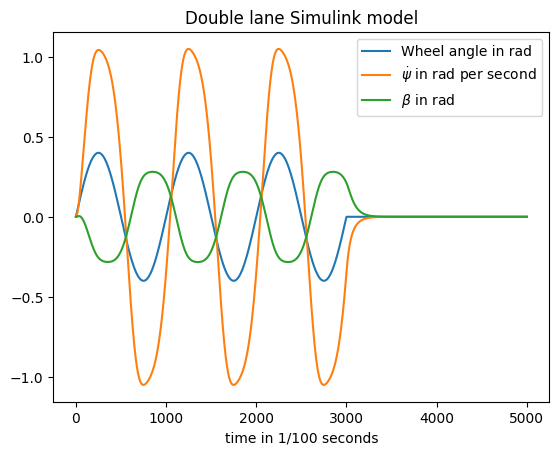

In [29]:
plot_input_and_states(psi=psi[1], beta=beta[1],
                      title="Double lane Simulink model")

## Single track model

We will use now [Python control systems library](https://python-control.readthedocs.io) to define the single track model in state space form:

\begin{equation*} \begin{bmatrix} \ddot{\psi}\\ \dot{\beta} \end{bmatrix}= \begin{bmatrix} -\frac{1}{v} \frac{c_{f} l_{v}^{2}+c_{r} l_{r}^{2}}{\Theta} & -\frac{c_{f} l_{f}-c_{r} l_{r}}{\Theta}\\ -1-\frac{1}{v^{2}} \frac{c_{f} l_{f}-c_{r} l_{r}}{m} & -\frac{1}{v} \frac{c_{f}+c_{r}}{m} \end{bmatrix} \begin{bmatrix} \dot{\psi}\\ \beta \end{bmatrix} + \begin{bmatrix} \frac{c_{f} l_{f}}{\Theta}\\ \frac{1}{v} \frac{c_{f}}{m} \end{bmatrix} \delta \end{equation*}

In [30]:
def single_track_model(c_f, c_r, l_f, l_r, m, theta, v):
    """
    Vehicle single track model from [p. 230, Schramm2018]
    states = [\dot{psi} in rad/s\\
              beta in rad]
    Args:
        c_f: Front cornering stiffness [N/rad]
        c_r: Rear cornering stiffness [N/rad]
        l_f: Distance CoG to front axles [m]
        l_r: Distance CoG to rear axles [m]
        m: Vehicle mass [kg]
        theta: Vehicle yaw inertia [kgm^2]
        v: Vehicle Speed [m/s]

    Returns:
        state space model
    """
    a_11 = -1 / v * (c_f * l_f ** 2 + c_r * l_r ** 2) / theta
    a_12 = -(c_f * l_f - c_r * l_r) / theta
    a_21 = -1 - 1 / (v ** 2) * (c_f * l_f - c_r * l_r) / m
    a_22 = -1 / v * (c_f + c_r) / m
    a_matrix = np.array([[a_11, a_12], [a_21, a_22]])

    b_1 = (c_f * l_f) / theta
    b_2 = 1 / v * c_f / m
    b_matrix = np.array([[b_1], [b_2]])

    c_matrix = np.array([[1, 0], [0, 1]])
    d_matrix = np.array([[0], [0]])

    return control.ss(a_matrix, b_matrix, c_matrix, d_matrix)

The first run with the initial parameters from the Simulink model is computed with this code block.

In [31]:
ss_model = single_track_model(
    c_f=12e3, c_r=11e3, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

response = control.forced_response(
    ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))
y = response.outputs
x = response.states

And the plot for the state space model becomes

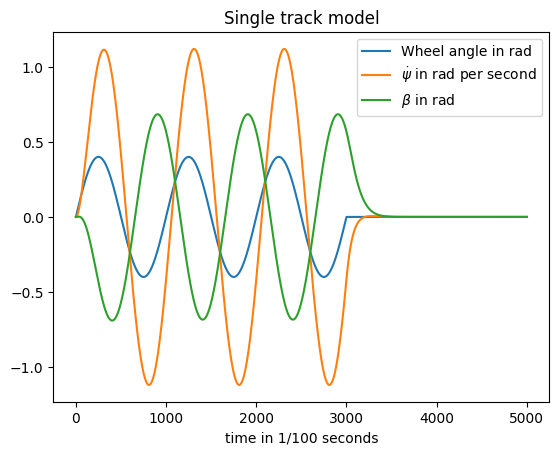

In [32]:
plot_input_and_states(psi=y[0], beta=y[1], title="Single track model")

This looks similar to the previous figure but a direct comprehension would be better. Hence, we will define a second plot function and an objective function.

In [33]:
def validation_plot(y_single_track_model):
    plt.figure()
    plt.plot(psi[1])
    plt.plot(y_single_track_model[0])
    plt.plot(beta[1])
    plt.plot(y_single_track_model[1])
    plt.legend([r"$\dot{\psi}$ reference", r"$\dot{\psi}$ model",
                r"$\beta$ reference", r"$\beta$ model"])
    plt.show()

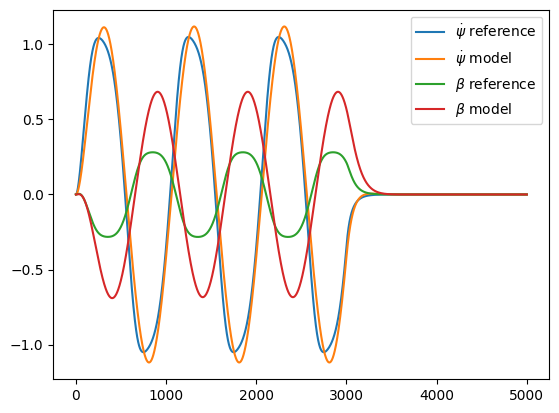

In [34]:
validation_plot(y)

The next function defines an objective measure of agreement between the states of the double lane model and the state space model. Note that both states, the yaw rate and the side slip angle are considered in the objective function and both states are normalized so that each state contributes equally.

In [35]:
def error(y_single_track_model):
    err0 = psi[1] - y_single_track_model[0]
    err1 = beta[1] - y_single_track_model[1]

    scaled_err0 = (err0 - np.min(err0)) / (np.max(err0) - np.min(err0))
    scaled_err1 = (err1 - np.min(err1)) / (np.max(err1) - np.min(err1))

    return np.sum(scaled_err0 ** 2) + np.sum(scaled_err1 ** 2)

Now, we can print the value of this objective function.

In [36]:
error(y)

np.float64(3082.0158633625824)

## Parameter calibration

We will use `minimize` from `scipy.optimize` to adjust the front and rear cornering stiffness. First, an objective function for minimizer is required. Note that a vector `x` becomes argument of this function and that the `single_track_model` is changed every time `x` changes.

In [37]:
def objective_func(x):
    ss_model = single_track_model(
        c_f=x[0], c_r=x[1], l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

    response = control.forced_response(
        ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))

    return error(response.outputs)

The next function actually conducts the optimization with `Powell` method, which was chosen rather randomly herein.

In [38]:
def parameter_fitting():
    x0 = np.array([11e3, 11e3])
    res = minimize(fun=objective_func, x0=x0,
                   method='Powell', options={'disp': True})
    print("Optimized params")
    print(res.x)
    return res.x

Let us run the optimizer and print the optimal values for the front and rear cornering stiffness.

In [39]:
optimized_params = parameter_fitting()

Optimization terminated successfully.
         Current function value: 2858.222914
         Iterations: 2
         Function evaluations: 58
Optimized params
[11130.3224368  11054.74421445]


## Optimized single track model

Now we run the single track model again with the calibrated parameters and plot the states and the value of the objective function.

In [40]:
ss_model = single_track_model(
    c_f=11130, c_r=11054, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

response = control.forced_response(
    ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))
y = response.outputs
x = response.states

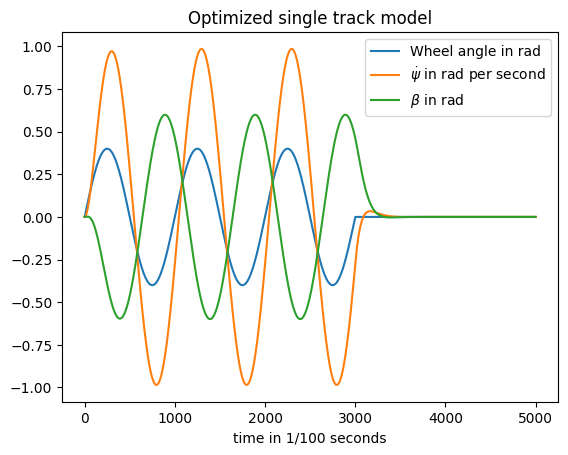

In [41]:
plot_input_and_states(psi=y[0], beta=y[1],
                      title="Optimized single track model")

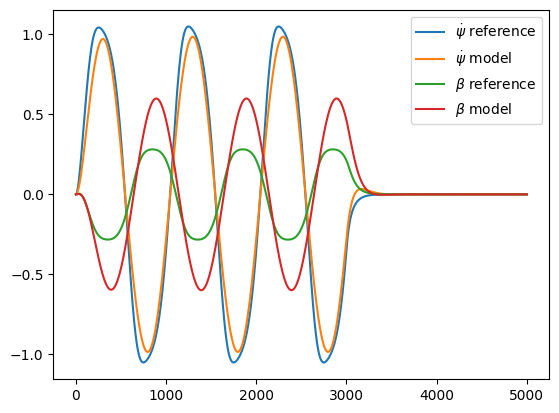

In [42]:
validation_plot(y)

In [43]:
error(y)

np.float64(2858.2323619717595)

The error dropped from 3082 with initial values to roughly 2858 after calibration. In conclusion, the single track model got better, however it is not capable to model the side slip angle well.

## Exercise:  Parameter calibration

<img src="../_static/exercise.png" alt="Exercise" width="75" align="left">

Now that we have some initial optimized single track model try to improve this result with other optimization methods. You can have a look at other methods from SciPy or you can implement a basic random search optimizer by yourself.

The random search simply throws random numbers on a given interval for the two parameters (front and rear cornering stiffness), computes the objective, and returns the best objective and respective parameters.

Here some pseudocode
```python
range_calibration_parameters = [min, max]
cut_off_cost = some_stopping_value

best_cost = some_large_number
best_params = init_params

for i until max_iteration:
    random_params = random(range_calibration_parameters)
    sim = simulate_single_track(random_params)
    current_cost = objective_function(meas, sim)

    if current_cost < best_cost:
        best_cost = current_cost
        best_params = random_params
```

What is your optimal result?